In [16]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [17]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

df_train = df_train[df_train.target > -30].reset_index(drop=True)

In [18]:
df_train["outliers"] = np.where(df_train.target < -30, 1, 0)

In [19]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [20]:
df_train, df_test = merge_new_feature("../input/feature_categorical_count.csv")
df_train, df_test = merge_new_feature("../input/feature_categorical_rete__by__categorical_count.csv")
df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/feature_catogorical_count_weighted_elapsed.csv")
df_train, df_test = merge_new_feature("../input/feature_latest_transaction_data__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_term_from_second_latest_to_latest.csv")
df_train, df_test = merge_new_feature("../input/feature_nunique_marchant__per__card_id.csv")
df_train, df_test = merge_new_feature("../input/feature_purchase_amount_mean_max_increase.csv")
df_train, df_test = merge_new_feature("../input/feature_frequency_mean_increase_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_card_count_increase_rate.csv")

In [21]:
dont_use = ['card_id', 'first_active_month','target', 'feature', 'outliers']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']

In [22]:
categorical = [
    "feature_1"
    , "feature_2"
    , "feature_3"
]

In [23]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',  #regression
    'max_depth': 8,  # -1
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',  #auc
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx], categorical_feature=categorical)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx], categorical_feature=categorical)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(target, oof))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.66223	valid_1's rmse: 1.66199
[200]	training's rmse: 1.63211	valid_1's rmse: 1.63237
[300]	training's rmse: 1.6145	valid_1's rmse: 1.61557
[400]	training's rmse: 1.60293	valid_1's rmse: 1.60518
[500]	training's rmse: 1.59472	valid_1's rmse: 1.59836
[600]	training's rmse: 1.58835	valid_1's rmse: 1.59355
[700]	training's rmse: 1.58288	valid_1's rmse: 1.59001
[800]	training's rmse: 1.57823	valid_1's rmse: 1.58726
[900]	training's rmse: 1.57424	valid_1's rmse: 1.58526
[1000]	training's rmse: 1.57061	valid_1's rmse: 1.58354
[1100]	training's rmse: 1.56727	valid_1's rmse: 1.58212
[1200]	training's rmse: 1.56415	valid_1's rmse: 1.58088
[1300]	training's rmse: 1.56121	valid_1's rmse: 1.57987
[1400]	training's rmse: 1.55845	valid_1's rmse: 1.57903
[1500]	training's rmse: 1.55581	valid_1's rmse: 1.5783
[1600]	training's rmse: 1.5533	valid_1's rmse: 1.57766
[1700]	training's rmse: 1.55085	valid_1's rmse

[500]	training's rmse: 1.59343	valid_1's rmse: 1.60315
[600]	training's rmse: 1.58719	valid_1's rmse: 1.59875
[700]	training's rmse: 1.58186	valid_1's rmse: 1.59525
[800]	training's rmse: 1.57724	valid_1's rmse: 1.5924
[900]	training's rmse: 1.57329	valid_1's rmse: 1.59025
[1000]	training's rmse: 1.56973	valid_1's rmse: 1.58847
[1100]	training's rmse: 1.56643	valid_1's rmse: 1.58696
[1200]	training's rmse: 1.56338	valid_1's rmse: 1.58566
[1300]	training's rmse: 1.56059	valid_1's rmse: 1.58457
[1400]	training's rmse: 1.5579	valid_1's rmse: 1.58362
[1500]	training's rmse: 1.55533	valid_1's rmse: 1.58274
[1600]	training's rmse: 1.55286	valid_1's rmse: 1.58199
[1700]	training's rmse: 1.55045	valid_1's rmse: 1.58131
[1800]	training's rmse: 1.54819	valid_1's rmse: 1.58077
[1900]	training's rmse: 1.54599	valid_1's rmse: 1.5803
[2000]	training's rmse: 1.54384	valid_1's rmse: 1.57987
[2100]	training's rmse: 1.54177	valid_1's rmse: 1.57949
[2200]	training's rmse: 1.53979	valid_1's rmse: 1.57915


Early stopping, best iteration is:
[7930]	training's rmse: 1.45397	valid_1's rmse: 1.57383
fold 4
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.65689	valid_1's rmse: 1.68346
[200]	training's rmse: 1.6266	valid_1's rmse: 1.6545
[300]	training's rmse: 1.60894	valid_1's rmse: 1.63829
[400]	training's rmse: 1.59742	valid_1's rmse: 1.62833
[500]	training's rmse: 1.58918	valid_1's rmse: 1.62163
[600]	training's rmse: 1.58288	valid_1's rmse: 1.61696
[700]	training's rmse: 1.57755	valid_1's rmse: 1.61328
[800]	training's rmse: 1.57294	valid_1's rmse: 1.61035
[900]	training's rmse: 1.56897	valid_1's rmse: 1.60812
[1000]	training's rmse: 1.56543	valid_1's rmse: 1.60639
[1100]	training's rmse: 1.56215	valid_1's rmse: 1.60483
[1200]	training's rmse: 1.5591	valid_1's rmse: 1.60352
[1300]	training's rmse: 1.55624	valid_1's rmse: 1.60244
[1400]	training's rmse: 1.55354	valid_1's rmse: 1.60157
[1500]	training's rmse: 1.55098	valid_1's rmse: 1.60072
[1600]	trai

1.5753718819414253

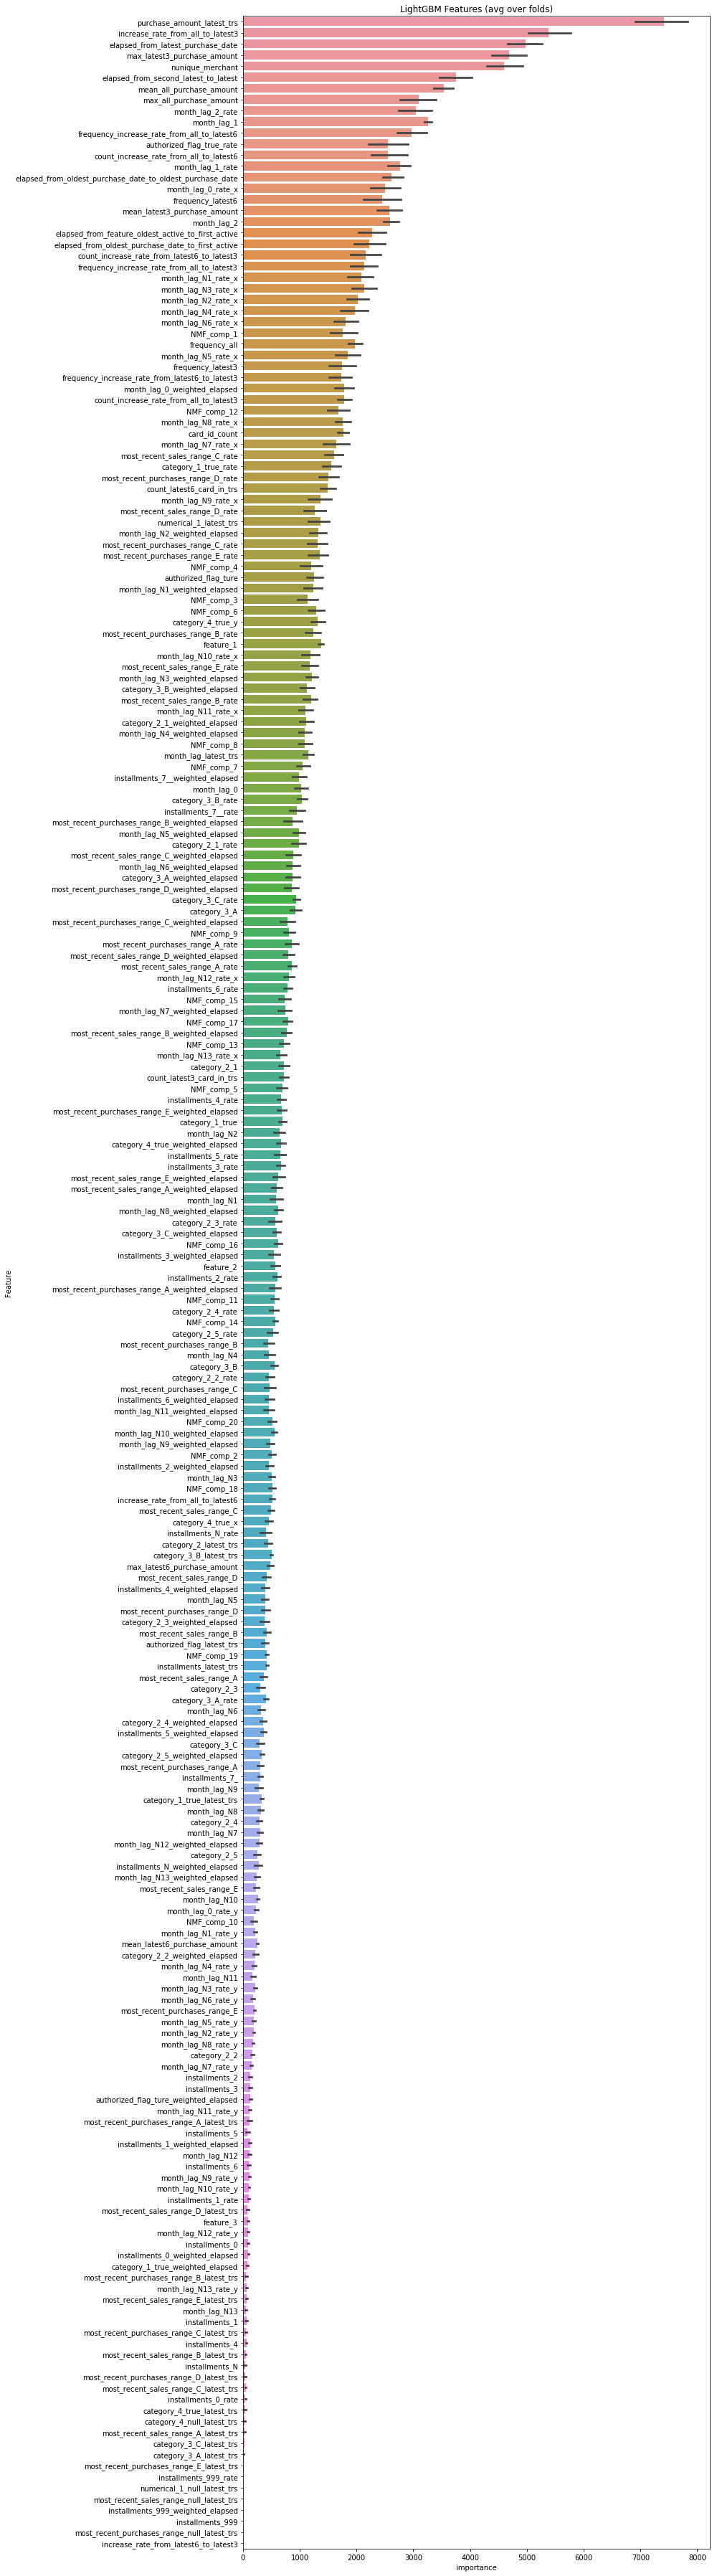

In [24]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [25]:
submission = pd.DataFrame({"card_id":df_test.card_id, "target":predictions})

In [26]:
submission.to_csv("../output/submission_no_outliers_model20181231.csv", index=False)